In [833]:
import sys
try:
    from pyathena import connect
except:
    print("Failed to import pyathena, trying to install it")
    !{sys.executable} -m pip install PyAthena
    from pyathena import connect
    print("successfully installed")
try:
    import psycopg2
except:
    print("Failed ot import psychopg2, trying to install it")
    !{sys.executable} -m pip install psycopg2-binary
    import psycopg2
    print("Successfully installed")
   
import pandas as pd
"""
# Modin is a faster pandas implementation that better uses multiple cores.
# You might have issues installing to get the right pandas version for it.
try:
    import modin.pandas as pd
    
except:
    print("Failed ot import modin, trying to install it")
    !{sys.executable} -m pip install modin
    !{sys.executable} -m pip install modin[ray]
    !{sys.executable} -m pip install --upgrade numpy
    import modin.pandas as pd
    print("Successfully installed")
 """   
    

import boto3
import boto3
import base64
from botocore.exceptions import ClientError
from datetime  import datetime, timedelta, date
import time

from athena_querying import *
from athena_common_queries import *

import csv

from matplotlib import cm #colormaps for pretty tables.

In [834]:
import creds

In [835]:
# if using jupyterlab and plotly doesn't work https://plot.ly/python/getting-started/#jupyterlab-support-python-35
install_jupyterlab_plotly_extensions_command = """
# Avoid "JavaScript heap out of memory" errors during extension installation
# (OS X/Linux)
export NODE_OPTIONS=--max-old-space-size=4096
# (Windows)
set NODE_OPTIONS=--max-old-space-size=4096

# Jupyter widgets extension
jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.0 --no-build

# jupyterlab renderer support
jupyter labextension install jupyterlab-plotly@1.1.0 --no-build

# FigureWidget support
jupyter labextension install plotlywidget@1.1.0 --no-build

# JupyterLab chart editor support (optional)
jupyter labextension install jupyterlab-chart-editor@1.2 --no-build

# Build extensions (must be done to activate extensions since --no-build is used above)
jupyter lab build

# Unset NODE_OPTIONS environment variable
# (OS X/Linux)
unset NODE_OPTIONS"""



    

In [836]:
import plotly.graph_objects as go
import plotly as py

import plotly.offline as off
import plotly.graph_objs as go
import numpy as np
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import os

#off.init_notebook_mode(connected=True)

In [837]:
# plotly, which seems to have endless issues to get working reliably on sagemaker.
if False:
    fig = make_subplots(1, 1)

    fig.add_trace(
        go.Pie(values=[1,2,3], labels=["a", "b", "c"]),
    )


    fig.show()
    
    


# Settings

In [838]:
#--- Analysis Settings --
num_days_to_analyse = 10
analysis_end_time = datetime.fromordinal(date.today().toordinal()) # start of today as we only get yesterday's data.  Note it's UTC time, so do multiple days
analysis_start_time = analysis_end_time - timedelta(days=num_days_to_analyse)
country_codes_to_analyse = ["hk", "sg"] # lower case
results_output_folder = './Blog AB Results'

test_urls_csv_filepath = {  # These originally come from https://docs.google.com/spreadsheets/d/1UdrncwVdObaA6d0lnvbAQCHBpQMzEhWPz5OTR9Syobo/edit#gid=0
    "id":"./SEO Test Urls/id_seo_test_urls.csv",
    "tw":"./SEO Test Urls/tw_seo_test_urls.csv",
    "sg": "./SEO Test Urls/sg_seo_test_urls.csv",
    "hk": "./SEO Test Urls/hk_seo_test_urls.csv",
}

exclude_seo_test_urls = True
only_seo_test_urls = False #useful for checking SEO test pages have sensible behaviour

# Getting Base Data

## Events from Athena

In [839]:
print("Connecting to Athena")
#athena_conn, athena_cursor = get_athena_conn()
athena = AthenaQuery()
athena.connect()

Connecting to Athena


In [ ]:
print("Running small test query to check the athena connection")
#pd.read_sql("select * from "+athena_database+"."+athena_raw_events_table+" limit 10", athena_conn)
athena.query("select * from "+athena_database+"."+athena_raw_events_table+" limit 5")

Running small test query to check the athena connection


,type,context,user,body,sent_at,event_id,version,received_at,partition_0,partition_1,partition_2
0,page,"{title=Kata OJK, 75 Persen Orang Indonesia Pak...","{anonymous_id=null, amp_id=amp-vXPuO6NvZYXNPpZ...","{event_name=PageView, data={title=null, status...",2019-12-16T00:00:00.597000+00:00,NaN,NaN,NaN,2019,12,22
1,event,{title=Ini Bedanya Orang Kaya Sama Kelas Menen...,{anonymous_id=537d7f22-f169-4606-b6f3-62c8713c...,"{event_name=Reading, data={title=Ini Bedanya O...",2019-12-22T00:00:08.913Z,NaN,NaN,NaN,2019,12,22
2,event,{title=電動機車補助少6千！三招教你 2019 年Gogoro怎麼買最便宜（2019....,{anonymous_id=f5d92ff8-8e01-423b-8523-a3e2695c...,"{event_name=Reading, data={title=電動機車補助少6千！三招教...",2019-12-22T00:00:09.244Z,NaN,NaN,NaN,2019,12,22
3,page,{title=【申請懶人包】中銀香港 直接開大陸戶口 3大細節要留意 （可綁支付寶微信） |...,{anonymous_id=e6861d1a-ded4-4bb7-aa80-a3ac5e4c...,"{event_name=PageView, data={title=null, status...",2019-12-22T00:02:21.656Z,NaN,NaN,NaN,2019,12,22
4,event,{title=Johor Bahru Guide - Where to Go & Cheap...,{anonymous_id=5fc286b1-3374-48e2-b34f-b36a34df...,"{event_name=Reading, data={title=Johor Bahru G...",2019-12-22T00:00:10.639Z,NaN,NaN,NaN,2019,12,22


In [ ]:
events = get_blog_events(country_codes_to_analyse, analysis_start_time, analysis_end_time, athena, limit =None)


Starting athena events query at 2020-03-12T06:43:44.281147
This might take some time
Getting the pageview and read events from 2020-03-02T00:00:00 to 2020-03-12T00:00:00
Query : 
    SELECT
    *
    , (CASE status
        WHEN 'Page Bottom Reached' THEN 100 
        WHEN 'Article Reading Completed' THEN 100 WHEN 'Article Body 100' THEN 100 
        WHEN 'Article Reading 75%' THEN 75 WHEN 'Article Body 75' THEN 75 
        WHEN 'Article Reading 50%' THEN 50 WHEN 'Article Body 50' THEN 50 
        WHEN 'Article Reading 25%' THEN 25 WHEN 'Article Body 25' THEN 25
        WHEN 'Article Reading Started' THEN 0 WHEN 'Article Loaded' THEN 0 
        ELSE 0 END) "article_read_depth"

    

    -- , CAST((("context"."page_url" LIKE '%utm_medium%') OR ("context"."page_url" LIKE '%gclid%')) AS boolean) "has_marketing_param"
    


    
    
    FROM
      (
          
    
    SELECT 
          CAST("from_iso8601_timestamp"("sent_at") AS timestamp) "sent_at_timestamp"
    , "sent_at"
    , subst

Ended query at 2020-03-12T06:44:52.813184

Setting data types
Ended query at 2020-03-12T06:44:55.946039
Taking 3 seconds
In total it took 71 seconds


In [ ]:
print("Got %i events"%len(events))
events.head(2)

Got 2479942 events


,sent_at_timestamp,sent_at,date,type,event_name,status,anonymous_id,amp_id,page_url,referrer,...,is_unbounce,is_embed,user_agent,device_type,browser_name,browser_major_version,browser_version,operating_system_name,operating_system_version,article_read_depth
0,2020-03-10 00:52:03.904,2020-03-10T00:52:03.904Z,2020-03-10,page,PageView,NaN,935bb95e-1767-4364-a4cc-4fd665b1e03c,NaN,https://blog.moneysmart.sg/invest/investing-sh...,https://blog.moneysmart.sg/invest/investment-b...,...,False,False,Mozilla/5.0 (iPhone; CPU iPhone OS 13_3_1 like...,mobile,Mobile Safari,13.0,13.0.5,iOS,13.3.1,0
1,2020-03-10 00:51:59.366,2020-03-10T00:51:59.366Z,2020-03-10,page,PageView,NaN,e3664bd5-8211-4719-9654-9248b0e1d63d,NaN,https://blog.moneysmart.sg/career/national-ser...,https://www.google.com/,...,False,False,Mozilla/5.0 (Linux; Android 9; SM-G955F) Apple...,mobile,Chrome,80.0,80.0.3987.132,Android,9,0


In [ ]:
events[events.country_code=="hk"][:20][["slug", "page_url"]]

,slug,page_url
99,/zh-hk/dining/%E9%8A%85%E9%91%BC%E7%81%A3-%E9%...,https://blog.moneysmart.hk/zh-hk/dining/%E9%8A...
100,/zh-hk/dining/%E9%8A%85%E9%91%BC%E7%81%A3-%E9%...,https://blog.moneysmart.hk/zh-hk/dining/%E9%8A...
107,/zh-hk/budgeting/%E9%9C%B2%E7%87%9F-%E6%96%B0%...,https://blog.moneysmart.hk/zh-hk/budgeting/%E9...
108,/zh-hk/budgeting/%E5%BD%B1%E7%89%87%E4%B8%B2%E...,https://blog.moneysmart.hk/zh-hk/budgeting/%E5...
129,/zh-hk/investment/%E9%9B%A2%E5%B2%B8%E6%88%B6%...,https://blog.moneysmart.hk/zh-hk/investment/%E...
131,/zh-hk/investment/%E8%82%A1%E6%81%AF-%E8%A8%88...,https://blog.moneysmart.hk/zh-hk/investment/%E...
132,/zh-hk/family/%E6%A8%93%E4%B8%8A%E6%BB%B4%E6%B...,https://blog.moneysmart.hk/zh-hk/family/%E6%A8...
144,/zh-hk/investment/%E4%B8%AD%E5%9C%8B%E5%BB%BA%...,https://blog.moneysmart.hk/zh-hk/investment/%E...
168,/zh-hk/budgeting/%E4%B8%AD%E9%8A%80-%E9%A6%99%...,https://blog.moneysmart.hk/zh-hk/budgeting/%E4...
179,/zh-hk/loans/%E5%82%B5%E5%8B%99%E9%87%8D%E7%B5...,https://blog.moneysmart.hk/zh-hk/loans/%E5%82%...


In [ ]:
# really this should be done in the common function, but doing here for now
# It's needed for calculating things like time between events for a given user
# It should be fairly safe as the conversion should be happening in SQL to make consistent.
if str(events.dtypes["sent_at_timestamp"])=="object": 
    print("Converting timestamp column into a datetime")
    events["sent_at_timestamp"] = pd.to_datetime(events["sent_at_timestamp"])
    events.dtypes

Converting timestamp column into a datetime


In [ ]:
# Check it's using half efficient data types (more category / bool, less object)
events.dtypes

sent_at_timestamp           datetime64[ns]
sent_at                             object
date                              category
type                              category
event_name                        category
status                            category
anonymous_id                        object
amp_id                              object
page_url                            object
referrer                          category
is_amp                                bool
is_test                               bool
is_control                            bool
slug                              category
country_code                      category
is_blog                               bool
is_unbounce                           bool
is_embed                              bool
user_agent                        category
device_type                       category
browser_name                      category
browser_major_version             category
browser_version                   category
operating_s

## Filtering out SEO Test Urls

This optionally removes the urls that are set to 100% v2, but with url as per v1, so they will go into the wrong category (and generally will distort as performance depends on page)

In [ ]:
def load_seo_test_urls(filepath):
    urls = []
    with open(filepath) as f:
        csv_reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(csv_reader):
            if i==0:
                print("Skipping first line of url file: %s"%row)
                continue
            urls.append(row[0].strip())

    return urls



In [ ]:
if exclude_seo_test_urls or only_seo_test_urls:
    seo_test_urls = {}
    for country_code in country_codes_to_analyse:
        seo_test_urls[country_code] = load_seo_test_urls(test_urls_csv_filepath[country_code])
        num_urls = len(seo_test_urls[country_code])
        print("Loaded %i SEO test urls for %s"%(num_urls,  country_code))

Skipping first line of url file: ['url']
Loaded 50 SEO test urls for hk
Skipping first line of url file: ['url']
Loaded 50 SEO test urls for sg


In [ ]:
if exclude_seo_test_urls or only_seo_test_urls:
    all_events = events # This will bloat memory, but it allows you to go back without reloading the source data.

In [ ]:
import re

In [ ]:
print("Possibly filtering out some urls")
num_events_before = len(events)
print("Before %i events"% num_events_before)

if exclude_seo_test_urls or only_seo_test_urls:
    
    seo_test_url_filter = "|".join(["|".join([re.escape(y) for y in z]) for z in list(seo_test_urls.values())[1:]])

if exclude_seo_test_urls:
    print("Excluding SEO test urls")
    events = all_events[~all_events.page_url.str.contains(seo_test_url_filter)]
    
    
elif only_seo_test_urls:
    print("Setting to only SEO test urls")
    events = all_events[all_events.page_url.str.contains(seo_test_url_filter)]
    
num_events_after = len(events)
print("After %i events (%.3f)"% (num_events_after, num_events_after / num_events_before))

Possibly filtering out some urls
Before 2479942 events
Excluding SEO test urls
After 2309683 events (0.931)


In [ ]:
#all_events.groupby("page_url").size()

In [ ]:
#events.groupby("page_url").size()

In [ ]:
#seo_test_url_filter

# Summary of Events by Day

In [ ]:
events_by_day = events.groupby([ "country_code", "date", "is_blog", "event_name"]).size().reset_index()
events_by_day.rename(columns={0:"count"}, inplace=True)
events_by_day

,country_code,date,is_blog,event_name,count
0,hk,2020-03-02,True,PageView,14051
1,hk,2020-03-02,True,Reading,26277
2,hk,2020-03-03,True,PageView,14041
3,hk,2020-03-03,True,Reading,25339
4,hk,2020-03-04,True,PageView,14014
5,hk,2020-03-04,True,Reading,24891
6,hk,2020-03-05,True,PageView,13190
7,hk,2020-03-05,True,Reading,23778
8,hk,2020-03-06,True,PageView,12948
9,hk,2020-03-06,True,Reading,22936


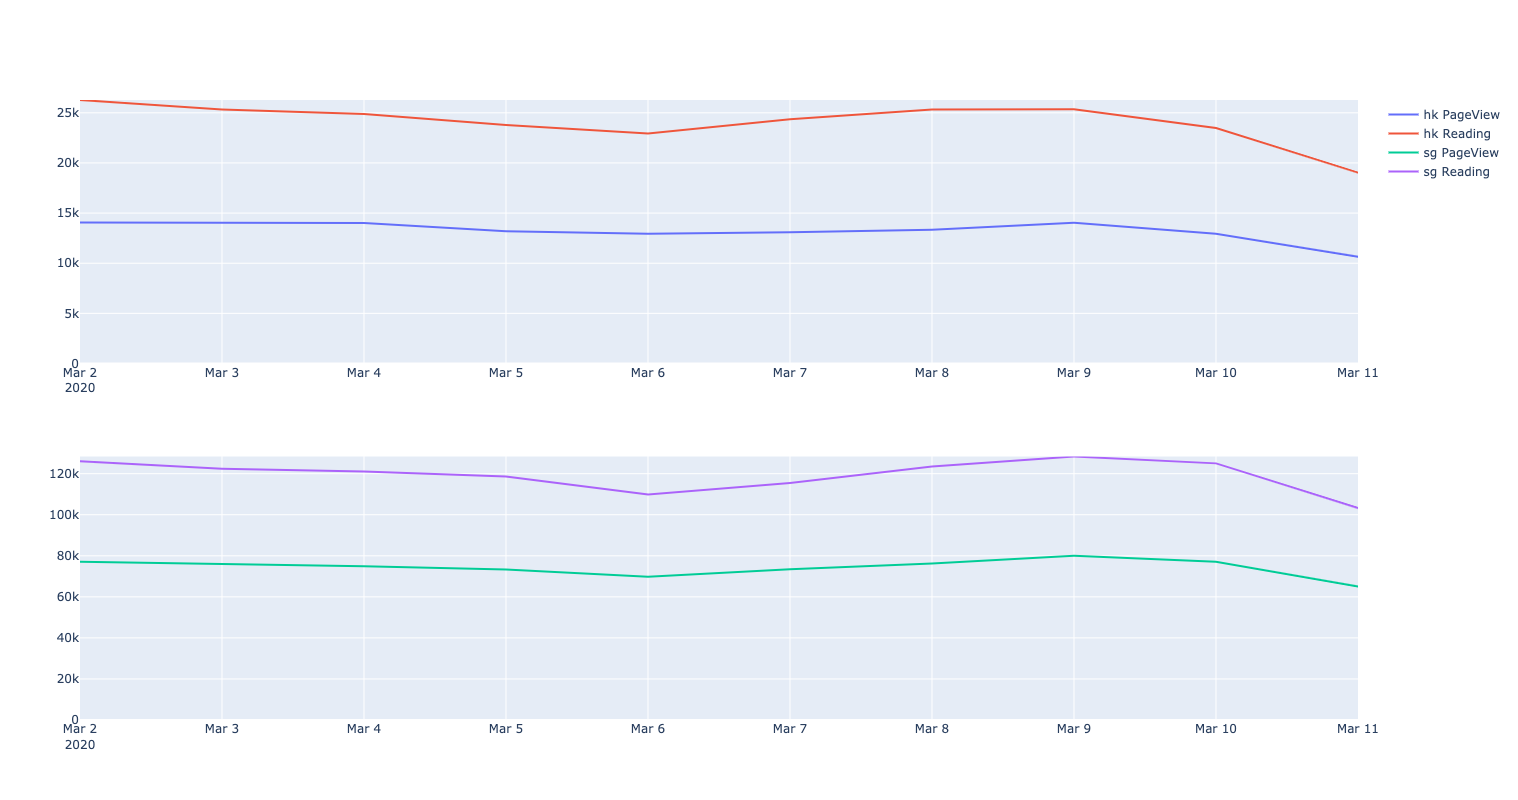

In [ ]:
countries = events_by_day.country_code.unique()
num_countries = len(countries)

unique_events = events_by_day.event_name.unique()
num_uniqe_events = len(unique_events)

fig = py.subplots.make_subplots(rows=num_countries, cols=1)

for i, country in enumerate(countries):
    max_count = 0
    for event_name in unique_events:
        line_label = country+" "+event_name
        df = events_by_day[(events_by_day.country_code==country) & (events_by_day.event_name == event_name)]
        max_count = max(max_count, df["count"].max())
        fig.add_trace(go.Scatter(x=df["date"], y=df["count"], mode='lines', name=line_label), row=i+1, col=1)
    fig.update_yaxes(range = [0, max_count], row=i+1, col=1)
fig.update_layout(height=800)
fig.show()

In [ ]:
pageview_events = events[events.event_name=="PageView"]

print("%i pageviews"%len(pageview_events))

875213 pageviews


# Pageviews Per User Per Day

In [ ]:
pageviews_per_user_per_day = pageview_events.groupby(["country_code","date","is_test", "anonymous_id"]).size().reset_index(name="count")

In [ ]:
pageviews_per_user_per_day.head(2)

,country_code,date,is_test,anonymous_id,count
0,hk,2020-03-02,False,000577a0-0ac1-4300-93b9-70bd2c9074b4,1
1,hk,2020-03-02,False,000679c6-1449-4f2e-9cbb-3968fdae94ec,1


In [ ]:
exclude_user_with_more_than_pageviews = 10
average_pageviews_per_user_per_day = pageviews_per_user_per_day[pageviews_per_user_per_day["count"]<=exclude_user_with_more_than_pageviews]\
    .groupby(["country_code","date", "is_test"])\
    .agg({"count":["mean", "sum", "count"]}) #, "count":"sum", "count":"sum"})
average_pageviews_per_user_per_day

count              
                                     mean    sum  count
country_code date       is_test                        
hk           2020-03-02 False    1.183359  12843  10853
                        True     1.188679   1134    954
             2020-03-03 False    1.194604  12664  10601
                        True     1.320000   1122    850
             2020-03-04 False    1.190328  12652  10629
                        True     1.277974   1085    849
             2020-03-05 False    1.195849  11870   9926
                        True     1.269767   1092    860
             2020-03-06 False    1.193217  11610   9730
                        True     1.288750   1031    800
             2020-03-07 False    1.192640  11992  10055
                        True     1.216867   1010    830
             2020-03-08 False    1.180092  12057  10217
                        True     1.248268   1081    866
             2020-03-09 False    1.197668  12530  10462
                        True     1.307779   1160    887
             2020-03-10 False    1.199593  11792   9830
                        True     1.250975    962    769
             2020-03-11 False    1.197319   9648   8058
                        True     1.267296    806    636
sg           2020-03-02 False    1.279509  70698  55254
                        True     1.397863   4318   3089
             2020-03-03 False    1.275886  69805  54711
                        True     1.404172   4308   3068
             2020-03-04 False    1.273249  68814  54046
                        True     1.387657   4317   3111
             2020-03-05 False    1.274133  68003  53372
                        True     1.382080   4026   2913
             2020-03-06 False    1.256989  64608  51399
                        True     1.389754   4015   2889
             2020-03-07 False    1.281497  67854  52949
                        True     1.424295   4139   2906
             2020-03-08 False    1.284005  70402  54830
                        True     1.416748   4348   3069
             2020-03-09 False    1.279926  74205  57976
                        True     1.398100   4562   3263
             2020-03-10 False    1.285130  71353  55522
                        True     1.377244   4297   3120
             2020-03-11 False    1.265064  60212  47596
                        True     1.437786   3767   2620

In [ ]:
average_pageviews_per_user_per_day.rename(columns={"sum":"num_pageviews", "count":"num_users", "mean":"pageviews_per_user"}, level=1, inplace=True)

In [ ]:
#average_pageviews_per_user_per_day.columns =average_pageviews_per_user_per_day.columns.get_level_values(0)
average_pageviews_per_user_per_day = average_pageviews_per_user_per_day.reset_index()
average_pageviews_per_user_per_day.rename(columns={"count":"aggregates"}, level=0, inplace=True)
#average_pageviews_per_user_per_day.rename(columns={average_pageviews_per_user_per_day.columns[3]:"pageviews_per_user", average_pageviews_per_user_per_day.columns[4]:"pageviews", average_pageviews_per_user_per_day.columns[5]:"users"},inplace=True)
average_pageviews_per_user_per_day
#TODO: sort out the column naming

country_code        date is_test         aggregates                        
                                    pageviews_per_user num_pageviews num_users
0            hk  2020-03-02   False           1.183359         12843     10853
1            hk  2020-03-02    True           1.188679          1134       954
2            hk  2020-03-03   False           1.194604         12664     10601
3            hk  2020-03-03    True           1.320000          1122       850
4            hk  2020-03-04   False           1.190328         12652     10629
5            hk  2020-03-04    True           1.277974          1085       849
6            hk  2020-03-05   False           1.195849         11870      9926
7            hk  2020-03-05    True           1.269767          1092       860
8            hk  2020-03-06   False           1.193217         11610      9730
9            hk  2020-03-06    True           1.288750          1031       800
10           hk  2020-03-07   False           1.192640         11992     10055
11           hk  2020-03-07    True           1.216867          1010       830
12           hk  2020-03-08   False           1.180092         12057     10217
13           hk  2020-03-08    True           1.248268          1081       866
14           hk  2020-03-09   False           1.197668         12530     10462
15           hk  2020-03-09    True           1.307779          1160       887
16           hk  2020-03-10   False           1.199593         11792      9830
17           hk  2020-03-10    True           1.250975           962       769
18           hk  2020-03-11   False           1.197319          9648      8058
19           hk  2020-03-11    True           1.267296           806       636
20           sg  2020-03-02   False           1.279509         70698     55254
21           sg  2020-03-02    True           1.397863          4318      3089
22           sg  2020-03-03   False           1.275886         69805     54711
23           sg  2020-03-03    True           1.404172          4308      3068
24           sg  2020-03-04   False           1.273249         68814     54046
25           sg  2020-03-04    True           1.387657          4317      3111
26           sg  2020-03-05   False           1.274133         68003     53372
27           sg  2020-03-05    True           1.382080          4026      2913
28           sg  2020-03-06   False           1.256989         64608     51399
29           sg  2020-03-06    True           1.389754          4015      2889
30           sg  2020-03-07   False           1.281497         67854     52949
31           sg  2020-03-07    True           1.424295          4139      2906
32           sg  2020-03-08   False           1.284005         70402     54830
33           sg  2020-03-08    True           1.416748          4348      3069
34           sg  2020-03-09   False           1.279926         74205     57976
35           sg  2020-03-09    True           1.398100          4562      3263
36           sg  2020-03-10   False           1.285130         71353     55522
37           sg  2020-03-10    True           1.377244          4297      3120
38           sg  2020-03-11   False           1.265064         60212     47596
39           sg  2020-03-11    True           1.437786          3767      2620

In [ ]:
#test_pv = average_pageviews_per_user_per_day[average_pageviews_per_user_per_day.is_test]
#control_pv = test_pv = average_pageviews_per_user_per_day[~average_pageviews_per_user_per_day.is_test]

## Overall Summary Pageviews Per User

The average here gives equal weighting per day, so might be distorted if you have a lot of variation between days and the traffic (or accuracy of those numbers say with splits changing ) changes by day


In [ ]:
pv_per_user_per_day_grouped_by_country = average_pageviews_per_user_per_day.groupby(["country_code", "is_test"]).mean()# .agg({["aggregates", "pageviews_per_user"]:"mean"})
#pv_per_user_per_day_grouped_by_country

In [ ]:
pv_summary = pd.pivot_table(pv_per_user_per_day_grouped_by_country, index=["country_code"], values=["aggregates"], columns=["is_test"], fill_value="")["aggregates"] #selecting aggregates removes top level
pv_summary.rename(columns={"pageviews_per_user":"pageviews_per_user_per_day"}, inplace=True)
#pv_summary


In [ ]:
pv_summary["pageviews_per_user_per_day", "v2_vs_v1"] = pv_summary["pageviews_per_user_per_day", True]-pv_summary["pageviews_per_user_per_day",False]

pv_summary["pageviews_per_user_per_day", "v2_vs_v1_%"] = (pv_summary["pageviews_per_user_per_day", True]-pv_summary["pageviews_per_user_per_day", False])/ pv_summary["pageviews_per_user_per_day", False] *100


pv_summary["pageviews_per_user_per_day", "v2_vs_v1_%_conversion_increase"] = (pv_summary["pageviews_per_user_per_day", True]-pv_summary["pageviews_per_user_per_day", False])/ (pv_summary["pageviews_per_user_per_day", False]-1) *100

#pv_summary["pageviews_per_user_per_day", "v2_vs_v1_%_weighted"] = (pv_summary["pageviews_per_user_per_day", True]-pv_summary["pageviews_per_user_per_day", False]) * (pv_summary["num_users", True]+pv_summary["num_users", False]) / (pv_summary["pageviews_per_user_per_day", False] * (pv_summary["num_users", True]+pv_summary["num_users", False]).sum()) *100 #turn into %




pv_summary.rename({"num_pageviews":"average_pageviews_per_day", 
                   "num_users":"average_users_per_day", 
                   "pageviews_per_user_per_day":"average_pageviews_per_user_per_day"
                  }, inplace=True)  #TODO: this isn't working for some reason, but I swear it was.

def color_summary(x):
    
    good_threshold = 0.03 # want it quite low.
    if x<0:
        return "background-color:red"
    else:
        
        gf = min(x/ good_threshold *255, 255)
        return "background-color: rgb(%i,%i,%i)" % (255 - gf, 255, 255-gf)

pv_summary["ab_split"] = pv_summary[ "num_pageviews", True] / (pv_summary["num_pageviews", True] + pv_summary["num_pageviews", False])

#pv_summary.style.applymap(color_summary, subset=pd.IndexSlice[:,pd.IndexSlice[:,"v2_vs_v1"]]) 
pv_summary.style.applymap(color_summary, subset=pv_summary.columns.get_loc_level('v2_vs_v1', level=1)[0]) 


## Pageviews Per User Broken down by Day

In [ ]:
pv = pd.pivot_table(average_pageviews_per_user_per_day, index=["country_code", "date"], values=["aggregates"], columns=["is_test"], fill_value="")


In [ ]:
pv["aggregates", "pageviews_per_user", "v2_vs_v1"] = pv["aggregates", "pageviews_per_user", True] - pv["aggregates", "pageviews_per_user", False]
pv["aggregates", "num_pageviews", "ab_split"] = pv["aggregates", "num_pageviews", True] / (pv["aggregates", "num_pageviews", True] + pv["aggregates", "num_pageviews", False])


In [ ]:

def color_negatives(x):
    if x>=0:
        #return "color:green"
        return ""
    return "background-color:pink"

pv.style.applymap(color_negatives, subset=["aggregates", "mean","v2_vs_v1"]) #TODO: this isn't working as intended, but hack works.

In [ ]:
pv2 = pv.reset_index()

In [ ]:
#pv2[(pv2.country_code==country)]["aggregates", "pageviews_per_user", True].values

In [ ]:
#pv2[pv2.country_code=="sg"].date

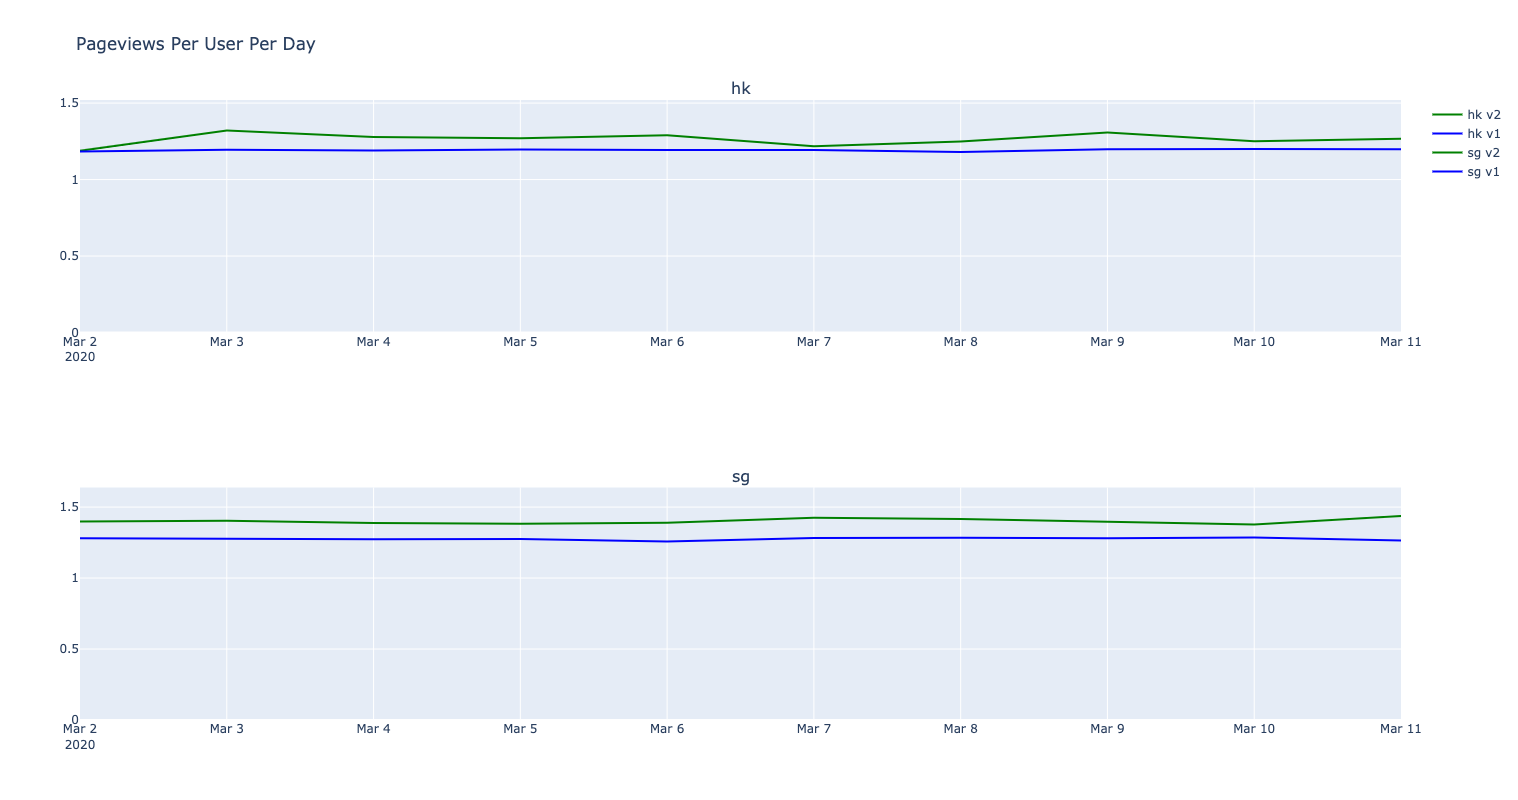

In [ ]:
countries = pv2.country_code.unique()
num_countries = len(countries)

is_test_states = [True, False]
num_unique_states = len(is_test_states)

fig = py.subplots.make_subplots(rows=num_countries, cols=1, subplot_titles=countries)

for i, country in enumerate(countries):
    max_val = 0
    for test_state in is_test_states:
        color = "green" if test_state else "blue"
        line_label = country+" "+("v2" if test_state else "v1")
        dates = pv2[pv2.country_code==country].date
        values = pv2[(pv2.country_code==country)]["aggregates", "pageviews_per_user", test_state].values 
        max_val = max(max_val, max(values))
        fig.add_trace(go.Scatter(x=dates, y=values, mode='lines', name=line_label, line_color=color), row=i+1, col=1)
    fig.update_yaxes(range = [0, max_val+0.2], row=i+1, col=1)
    
fig.update_layout(height=800, title="Pageviews Per User Per Day")

fig.show()


In [ ]:
# average_pageviews_per_user_per_day = pageviews_per_user_per_day.groupby(["country_code","date", "is_test"]).agg(average_pageviews_per_user = ("count","mean"), num_users=  ("count","sum"), num_pageviews = ("count", "sum"))

In [ ]:
#average_pageviews_per_user_per_day


# Scroll Depth Analysis

## Convert Raw Pageview Events Into Scroll Depth Summary



In [ ]:
cols_to_group_by = [z for z in list(events.columns) if z not in ["article_read_depth", "sent_at_timestamp", "sent_at", "event_name", "status"]]
#cols_to_group_by

In [ ]:
events[["event_name", "status", "article_read_depth"]].head()

,event_name,status,article_read_depth
0,PageView,NaN,0
3,Reading,Article Body 50,50
4,PageView,NaN,0
5,PageView,NaN,0
7,PageView,NaN,0


In [ ]:
cols_to_group_by = ["country_code", "date","is_test", "page_url","anonymous_id", "slug"]

scroll_df = events.groupby(cols_to_group_by).agg({"article_read_depth":"max", "sent_at_timestamp":("min", "max")})

In [ ]:
scroll_df.reset_index(col_level=1, inplace=True)

In [ ]:
#NB: There are some massive outliars here.
scroll_df["time_on_page"] = (scroll_df["sent_at_timestamp", "max"] - scroll_df["sent_at_timestamp", "min"]).dt.total_seconds()

In [ ]:
time_on_page_mins_threshold = 20
long_time_on_pages = scroll_df[scroll_df["time_on_page"]>time_on_page_mins_threshold*60]
print("found %i taking an (maybe excessively) long time on the page of %i or %.2f of total" %(len(long_time_on_pages), len(scroll_df), len(long_time_on_pages)/len(scroll_df)))

found 40993 taking an (maybe excessively) long time on the page of 773047 or 0.05 of total


In [ ]:
#df.rename({5:"max_scroll_depth",6:"min_time", 7:"max_time", 8:"time_on_page"}, axis=1)
old_col_names = ["".join(z) for z in scroll_df.columns.values] #hacks for multi-level index.
new_col_names = list(old_col_names) #copy
new_col_names[6] = "max_article_read_depth"
new_col_names[7] = "min_time"
new_col_names[8] = "max_time"
new_col_names[9] ="time_on_page"
#df.rename(columns={df.columns[5]:"mouse"})
scroll_df.columns=new_col_names
scroll_df.head(5)

,country_code,date,is_test,page_url,anonymous_id,slug,max_article_read_depth,min_time,max_time,time_on_page
0,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e5%84%aa...,9cd21bf1-414f-40b2-9836-15fc3d38199c,/budgeting/%e5%84%aa%e6%83%a0%e7%a2%bc-%e5%a4%...,75,2020-03-02 05:12:53.801,2020-03-02 05:14:12.268,78.467
1,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e6%b8%af...,6a5a96db-d203-46b0-9ea1-c3693596376a,/budgeting/%e6%b8%af%e5%85%83-%e5%ae%9a%e6%9c%...,25,2020-03-02 15:21:50.505,2020-03-02 15:22:16.800,26.295
2,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e8%b2%a1...,4bec7747-2a0d-478d-a76a-cda42fa8ec5b,/budgeting/%e8%b2%a1%e6%94%bf%e9%a0%90%e7%ae%9...,100,2020-03-02 13:28:06.721,2020-03-02 13:30:35.344,148.623
3,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e8%b2%a1...,ddb58b28-8a04-444b-925e-38d7a78b9d51,/budgeting/%e8%b2%a1%e6%94%bf%e9%a0%90%e7%ae%9...,100,2020-03-02 14:24:58.108,2020-03-02 14:28:42.879,224.771
4,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/bno-%e7%9...,1aa2b07c-01aa-4c75-8998-590e3227b4a6,/budgeting/bno-%e7%94%b3%e8%ab%8b-%e8%ad%b7%e7...,75,2020-03-02 06:59:11.741,2020-03-02 07:03:37.787,266.046


In [ ]:
scroll_by_day = scroll_df.groupby(["country_code","is_test", "date"]).agg({"max_article_read_depth":("mean", "count")})

In [ ]:
#scroll_by_day.reset_index()

In [ ]:
scroll_by_day  = pd.pivot_table(scroll_by_day, index=["country_code", "date"], values=["max_article_read_depth"], columns=["is_test"], fill_value="")

In [ ]:
scroll_by_day.rename(columns={"mean":"av_max_article_read_depth"}, inplace=True)


In [ ]:
#scroll_by_day.columns = scroll_by_day.columns.droplevel(level=1)

In [ ]:
scroll_by_day

max_article_read_depth        \
                                         count         
is_test                                  False True    
country_code date                                      
hk           2020-03-02                  11698   988   
             2020-03-03                  11443   934   
             2020-03-04                  11458   961   
             2020-03-05                  10741   935   
             2020-03-06                  10608   861   
             2020-03-07                  10759   879   
             2020-03-08                  10980   967   
             2020-03-09                  11306  1034   
             2020-03-10                  10574   857   
             2020-03-11                   8743   691   
sg           2020-03-02                  64058  3735   
             2020-03-03                  63504  3659   
             2020-03-04                  62520  3663   
             2020-03-05                  61351  3468   
             2020-03-06                  58296  3349   
             2020-03-07                  61029  3537   
             2020-03-08                  63595  3619   
             2020-03-09                  66616  3867   
             2020-03-10                  64329  3726   
             2020-03-11                  54509  3200   

                                                              
                        av_max_article_read_depth             
is_test                                     False      True   
country_code date                                             
hk           2020-03-02                 51.662677  42.965587  
             2020-03-03                 50.456611  45.101713  
             2020-03-04                 49.906179  41.909469  
             2020-03-05                 50.572572  44.037433  
             2020-03-06                 49.292986  46.283391  
             2020-03-07                 51.600985  46.530148  
             2020-03-08                 52.629781  47.078594  
             2020-03-09                 50.928710  44.584139  
             2020-03-10                 50.714016  46.645274  
             2020-03-11                 49.819856  46.454414  
sg           2020-03-02                 46.270177  45.589023  
             2020-03-03                 45.386117  45.060126  
             2020-03-04                 45.506238  45.181545  
             2020-03-05                 45.586462  44.831315  
             2020-03-06                 44.270619  43.841445  
             2020-03-07                 44.412083  44.465649  
             2020-03-08                 45.692271  44.439072  
             2020-03-09                 45.340083  42.668735  
             2020-03-10                 45.755025  44.323671  
             2020-03-11                 44.567870  44.312500

In [ ]:
scroll_by_day["max_article_read_depth","av_max_article_read_depth", "v2_vs_v1_av_read_depth"] = \
    scroll_by_day["max_article_read_depth","av_max_article_read_depth", True]-scroll_by_day["max_article_read_depth","av_max_article_read_depth", False] 

In [ ]:
def color_negatives(x):
    if x>=0:
        #return "color:green"
        return ""
    return "background-color:pink"

scroll_by_day.style.applymap(color_negatives) 

# Scroll Depth Breakdown

In [ ]:
scroll_by_depth = scroll_df.groupby(["country_code","is_test", "max_article_read_depth"]).size().reset_index(name="num_pageviews")
#scroll_by_depth["%_pageviews"] >>
#scroll_by_depth

In [ ]:
totals = scroll_by_depth.groupby(["country_code", "is_test"]).sum()["num_pageviews"].reset_index()
#.rename(columns={"num_pageviews":"total_pageviews"})
totals = totals.rename(columns={"num_pageviews":"total_pageviews"})
#totals

In [ ]:
scroll_by_depth = scroll_by_depth.merge(totals, how="left", on=["country_code", "is_test"]) 
scroll_by_depth["fraction_pageviews"] = scroll_by_depth["num_pageviews"] / scroll_by_depth["total_pageviews"]

In [ ]:
#scroll_by_depth

In [ ]:
scroll_by_depth_pv = pd.pivot_table(scroll_by_depth,
                    index=["country_code", "max_article_read_depth"], 
                    values=["num_pageviews", "total_pageviews", "fraction_pageviews"],   
                    columns=["is_test"],   # 
                    fill_value="")
scroll_by_depth_pv

fraction_pageviews            \
is_test                                          False     True    
country_code max_article_read_depth                                
hk           0                                0.230671  0.269353   
             25                               0.136783  0.170967   
             50                               0.195051  0.212364   
             75                               0.245536  0.182058   
             100                              0.191958  0.165257   
sg           0                                0.337666  0.373447   
             25                               0.153606  0.133099   
             50                               0.117153  0.105491   
             75                               0.142156  0.117187   
             100                              0.249420  0.270776   

                                    num_pageviews        total_pageviews  \
is_test                                     False  True            False   
country_code max_article_read_depth                                        
hk           0                              24984   2453          108310   
             25                             14815   1557          108310   
             50                             21126   1934          108310   
             75                             26594   1658          108310   
             100                            20791   1505          108310   
sg           0                             209288  13378          619807   
             25                             95206   4768          619807   
             50                             72612   3779          619807   
             75                             88109   4198          619807   
             100                           154592   9700          619807   

                                            
is_test                              True   
country_code max_article_read_depth         
hk           0                        9107  
             25                       9107  
             50                       9107  
             75                       9107  
             100                      9107  
sg           0                       35823  
             25                      35823  
             50                      35823  
             75                      35823  
             100                     35823

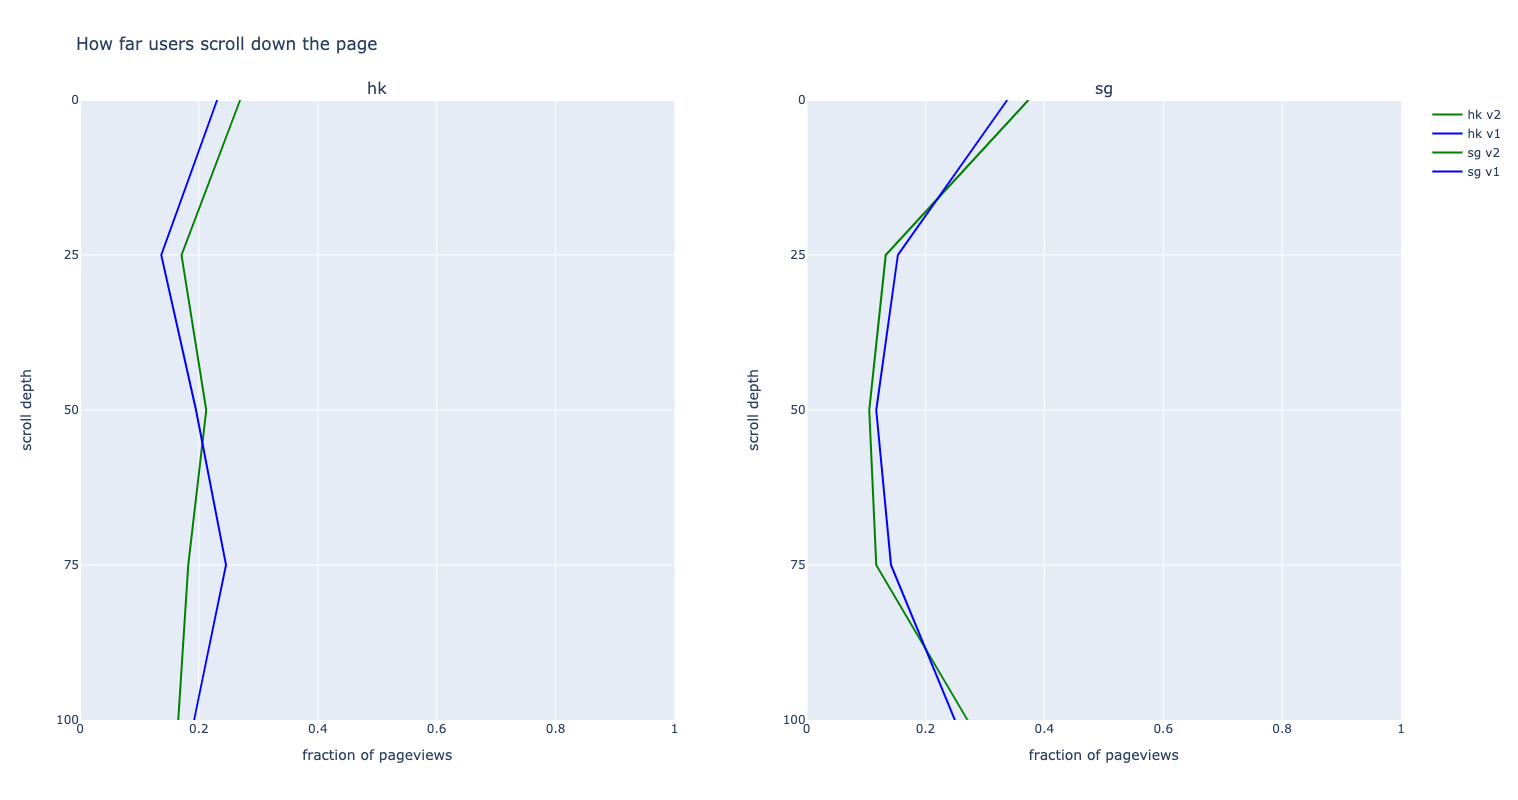

In [ ]:
countries = scroll_by_depth.country_code.unique()
num_countries = len(countries)
fig = py.subplots.make_subplots(rows=1, cols=num_countries, subplot_titles=countries) # plot vertically side by side
for i, country_code in enumerate(countries):
    for is_test, name, color in[(True, "v2", "green"), (False, "v1", "blue")]:
        #plot depth vertically from 0 at the top of the page.
        line_label =  " ".join([country_code, name])
        depths = scroll_by_depth[(scroll_by_depth.country_code == country_code) & (scroll_by_depth.is_test == is_test)]["max_article_read_depth"]  ## 	country_code	is_test	max_article_read_depth
        fraction_at_depths = scroll_by_depth[(scroll_by_depth.country_code == country_code) & (scroll_by_depth.is_test == is_test)]["fraction_pageviews"]
        fig.add_trace(go.Scatter(x=fraction_at_depths, y=depths, mode='lines', name=line_label, line_color=color), row=1, col=i+1)
        
    fig.update_yaxes(range = [100,0], row=1, col=i+1, tick0=0, dtick=25, title_text="scroll depth")
    fig.update_xaxes(range = [0, 1], row=1, col=i+1, title_text = "fraction of pageviews")
        
fig.update_layout(height=800, width=400* num_countries, title="How far users scroll down the page")

fig.show()


## Analysing Scroll Depth by Browser etc

In [ ]:
scroll_df.head()

,country_code,date,is_test,page_url,anonymous_id,slug,max_article_read_depth,min_time,max_time,time_on_page
0,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e5%84%aa...,9cd21bf1-414f-40b2-9836-15fc3d38199c,/budgeting/%e5%84%aa%e6%83%a0%e7%a2%bc-%e5%a4%...,75,2020-03-02 05:12:53.801,2020-03-02 05:14:12.268,78.467
1,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e6%b8%af...,6a5a96db-d203-46b0-9ea1-c3693596376a,/budgeting/%e6%b8%af%e5%85%83-%e5%ae%9a%e6%9c%...,25,2020-03-02 15:21:50.505,2020-03-02 15:22:16.800,26.295
2,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e8%b2%a1...,4bec7747-2a0d-478d-a76a-cda42fa8ec5b,/budgeting/%e8%b2%a1%e6%94%bf%e9%a0%90%e7%ae%9...,100,2020-03-02 13:28:06.721,2020-03-02 13:30:35.344,148.623
3,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e8%b2%a1...,ddb58b28-8a04-444b-925e-38d7a78b9d51,/budgeting/%e8%b2%a1%e6%94%bf%e9%a0%90%e7%ae%9...,100,2020-03-02 14:24:58.108,2020-03-02 14:28:42.879,224.771
4,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/bno-%e7%9...,1aa2b07c-01aa-4c75-8998-590e3227b4a6,/budgeting/bno-%e7%94%b3%e8%ab%8b-%e8%ad%b7%e7...,75,2020-03-02 06:59:11.741,2020-03-02 07:03:37.787,266.046


In [ ]:
# Need to get the browser type to join with the anonymous_id if it's not in this df.

In [ ]:
# events.set_index("anonymous_id")

In [ ]:
#This is kind of slow
start_time = datetime.now()
print("starting at %s"%start_time)
cols_to_group_full = ["anonymous_id", "device_type", "browser_name", "browser_major_version", "browser_version", "operating_system_name", "operating_system_version"] #super slow
cols_to_group = ["anonymous_id", "device_type", "browser_name", "browser_major_version","operating_system_name"]
anonymous_id_to_browser = events[cols_to_group].groupby(["anonymous_id"], observed=True).first() #observed=True should improve performance with category types.
end_time = datetime.now()
dtime = (end_time -start_time).total_seconds()
print("took %.1f seconds"%dtime)

starting at 2020-03-12 06:45:16.005632


In [922]:
anonymous_id_to_browser.head()

,device_type,browser_name,browser_major_version,operating_system_name
anonymous_id,,,,
00005d7a-fefd-499c-a3a0-67bf9cfa9b0c,mobile,Chrome,80.0,Android
0000802d-0eea-4770-8aec-4301a4f9df0a,mobile,Chrome,80.0,Android
00008888-6fd4-4dc8-b9f9-863692b3ed5d,mobile,Mobile Safari,13.0,iOS
0000c622-794e-475f-9d8d-08b20d33925b,mobile,Mobile Safari,13.0,iOS
00010043-3088-4c48-b6af-77dd08f9be72,desktop,Chrome,80.0,Windows


In [923]:
#join to scroll depth data to help segment

In [924]:

scroll_df_with_browser = scroll_df.merge(anonymous_id_to_browser, how="left", on="anonymous_id") #probably would be better to look at indexes for this kind of operation.

In [925]:
scroll_df_with_browser.head()

,country_code,date,is_test,page_url,anonymous_id,slug,max_article_read_depth,min_time,max_time,time_on_page,device_type,browser_name,browser_major_version,operating_system_name
0,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e5%84%aa...,9cd21bf1-414f-40b2-9836-15fc3d38199c,/budgeting/%e5%84%aa%e6%83%a0%e7%a2%bc-%e5%a4%...,75,2020-03-02 05:12:53.801,2020-03-02 05:14:12.268,78.467,desktop,Firefox,73.0,Windows
1,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e6%b8%af...,6a5a96db-d203-46b0-9ea1-c3693596376a,/budgeting/%e6%b8%af%e5%85%83-%e5%ae%9a%e6%9c%...,25,2020-03-02 15:21:50.505,2020-03-02 15:22:16.800,26.295,desktop,Safari,11.0,Mac OS
2,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e8%b2%a1...,4bec7747-2a0d-478d-a76a-cda42fa8ec5b,/budgeting/%e8%b2%a1%e6%94%bf%e9%a0%90%e7%ae%9...,100,2020-03-02 13:28:06.721,2020-03-02 13:30:35.344,148.623,mobile,Mobile Safari,13.0,iOS
3,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/%e8%b2%a1...,ddb58b28-8a04-444b-925e-38d7a78b9d51,/budgeting/%e8%b2%a1%e6%94%bf%e9%a0%90%e7%ae%9...,100,2020-03-02 14:24:58.108,2020-03-02 14:28:42.879,224.771,mobile,Chrome,80.0,Android
4,hk,2020-03-02,False,https://blog.moneysmart.hk/budgeting/bno-%e7%9...,1aa2b07c-01aa-4c75-8998-590e3227b4a6,/budgeting/bno-%e7%94%b3%e8%ab%8b-%e8%ad%b7%e7...,75,2020-03-02 06:59:11.741,2020-03-02 07:03:37.787,266.046,desktop,Chrome,80.0,Windows


In [926]:
def color_scroll_diff(x):
    #return "background-color: red"
    error_space = 3
    saturated_level = 30
    cx = abs(x)/saturated_level*255
    
    #if x>error_space or x<(-1*error_space):
     #   return
        
    if x<0:
        return "background-color: rgb(%i,%i,%i)" % (255, 255-cx, 255-cx)
    
    if x>0:
        return "background-color: rgb(%i,%i,%i)" % (255-cx, 255, 255-cx)


def create_scroll_depth_table(df, cols_to_segment_by, with_highlighting = True):
    cols_to_group_by = ["country_code", "is_test"]+ cols_to_segment_by
    grouped_by_device_type = df.groupby(cols_to_group_by, observed=True).agg({"max_article_read_depth":"mean", "anonymous_id":"size"}).reset_index()
    grouped_by_device_type.rename(columns={"anonymous_id":"num_pageviews", "max_article_read_depth":"av_max_article_read_depth"}, inplace=True)
    grouped_by_device_type

    index_cols = ["country_code",]+ cols_to_segment_by
    grouped_by_device_type_pv = pd.pivot_table(grouped_by_device_type,
                        index=index_cols, 
                        values=["av_max_article_read_depth", "num_pageviews"],
                        columns=["is_test"],   # 
                        fill_value=0)
    
    grouped_by_device_type_pv["av_max_article_read_depth", "v2_vs_v1"] = grouped_by_device_type_pv['av_max_article_read_depth', True]-grouped_by_device_type_pv['av_max_article_read_depth', False]
    
    if with_highlighting:
        grouped_by_device_type_pv.style.applymap(color_scroll_diff)
        #return grouped_by_device_type_pv.style.applymap(color_scroll_diff, subset=grouped_by_device_type_pv.columns.get_loc_level('v2_vs_v1', level=1)[0]) 
    
    return grouped_by_device_type_pv

def color_scroll_depth_table(g):
    return g.style.applymap(color_scroll_diff, subset=g.columns.get_loc_level('v2_vs_v1', level=1)[0]) 

In [927]:
grouped_by_device_type_pv =  create_scroll_depth_table(scroll_df_with_browser,["device_type"] )               
g = grouped_by_device_type_pv[grouped_by_device_type_pv["num_pageviews", True]>100]


color_scroll_depth_table(g)


In [928]:
#threshold_for_interesting_on_test = len(scroll_df_with_browser[scroll_df_with_browser.is_test=True])/50

grouped_by_device_type_pv =  create_scroll_depth_table(scroll_df_with_browser,["device_type", "operating_system_name"] )               
g = grouped_by_device_type_pv[grouped_by_device_type_pv["num_pageviews", True]>100]
color_scroll_depth_table(g)

In [929]:
grouped_by_device_type_pv =  create_scroll_depth_table(scroll_df_with_browser,["device_type", "operating_system_name", "browser_name", "browser_major_version"] )           

g = grouped_by_device_type_pv[grouped_by_device_type_pv["num_pageviews", True]>100]
#color_scroll_depth_table(g) - not working for some reason


In [930]:
#color_scroll_depth_table(g) 

In [932]:
g #.style.apply(lambda x:"background-color: red", subset=g.columns.get_loc_level('v2_vs_v1', level=1)[0], axis=1)

av_max_article_read_depth  \
is_test                                                                                                  False   
country_code device_type operating_system_name browser_name    browser_major_version                             
hk           desktop     Linux                 Chrome Headless 73.0                                   0.000000   
                         Mac OS                Chrome          80.0                                  50.123196   
                                               Safari          13.0                                  56.602972   
                         Windows               Chrome          80.0                                  54.101001   
             mobile      Android               Chrome          80.0                                  54.285165   
                                               Samsung Browser 11.0                                  54.365466   
                         iOS                   Chrome          80.0                                  48.881493   
                                               Mobile Safari   12.0                                  46.475312   
                                                               13.0                                  48.930923   
sg           desktop     Mac OS                Chrome          79.0                                  51.632589   
                                                               80.0                                  50.404160   
                                               Safari          12.0                                  55.572792   
                                                               13.0                                  52.139946   
                         Windows               Chrome          77.0                                  50.756677   
                                                               79.0                                  50.049947   
                                                               80.0                                  49.350237   
                                               Edge            18.0                                  50.924724   
                                               Firefox         73.0                                  44.834481   
                                               IE              11.0                                  50.579897   
             mobile      Android               Chrome          38.0                                  30.918266   
                                                               78.0                                  45.436164   
                                                               79.0                                  44.179789   
                                                               80.0                                  45.573866   
                                               Facebook        259.0                                 46.898404   
                                                               260.0                                 38.614271   
                                               Samsung Browser 10.0                                  43.286662   
                                                               11.0                                  44.400191   
                         iOS                   Chrome          80.0                                  44.423604   
                                               GSA             94.0                                  47.332421   
                                                               96.0                                  48.713060   
                                               Mobile Safari   11.0                                  38.270826   
                                                               12.0                                  40.819619   
                                                               13.0                            

## Problem Pages by Scroll Depth

Might indicate pages that are loading, but then have very poor experience so people drop off.  Extreme case would be the page not loading.

We have seen examples of this in the past.

In [933]:
problem_pages_by_depth =  create_scroll_depth_table(scroll_df_with_browser,["slug"] )

In [934]:
# Add some nice urls to make life easier
problem_pages_by_depth["url"] = problem_pages_by_depth.reset_index().apply(lambda x: "https://blog.moneysmart."+x["country_code"]+x["slug"], axis=1) # I think should be able to make faster, but it's ok.
problem_pages_by_depth.reset_index(inplace=True)
#problem_pages_by_depth.drop(columns=["slug"], inplace=True)
#problem_pages_by_depth.reset_index(inplace=True)
#problem_pages_by_depth["url"] = "https://blog.moneysmart."+problem_pages_by_depth["country_code"]+ problem_pages_by_depth["url"]
#problem_pages_by_depth["url"] = "https://blog.moneysmart."+problem_pages_by_depth.country_code



In [935]:
"""
def make_clickable(val):
    # target _blank to open new window
    print("cow")
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

problem_pages_by_depth[:100].style.format({'url': make_clickable}, subset=["url", ])
#problem_pages_by_depth.head()
"""

'\ndef make_clickable(val):\n    # target _blank to open new window\n    print("cow")\n    return \'<a target="_blank" href="{}">{}</a>\'.format(val, val)\n\nproblem_pages_by_depth[:100].style.format({\'url\': make_clickable}, subset=["url", ])\n#problem_pages_by_depth.head()\n'

In [936]:
g = problem_pages_by_depth[(problem_pages_by_depth["num_pageviews", True]>100) & (problem_pages_by_depth["av_max_article_read_depth", True]<40)].sort_values(("num_pageviews", False))

color_scroll_depth_table(g)

In [937]:
g = problem_pages_by_depth[(problem_pages_by_depth["num_pageviews", True]>100) \
                       & ( (problem_pages_by_depth["av_max_article_read_depth", True] - problem_pages_by_depth["av_max_article_read_depth", False]) <-5)].sort_values(["country_code", ("num_pageviews", False)])

color_scroll_depth_table(g)

## Problem Pages by AB Split

Might indicate pages that don't load at all on v2

In [938]:
ab_split = len(scroll_df_with_browser[scroll_df_with_browser.is_test==True]) / len(scroll_df_with_browser)
g = problem_pages_by_depth[(problem_pages_by_depth["num_pageviews", False]>100) & ((problem_pages_by_depth["num_pageviews", True] / problem_pages_by_depth["num_pageviews", False]) < 0.5*ab_split)].sort_values(["country_code", ("num_pageviews", False)])


# Queries to Add
```

select * from id_pageview_metrics where time_on_page_seconds <5 and max_article_read_depth = 100 limit 100
```
---
```
select * from id_engagement_summary order by day_str, is_test 

```

# Data Cleaning

* Remove what looks like bots / any really heavy users (not sure if most bots will trigger analytics events)


In [ ]:
non_amp_events = events[events.is_amp==False]

# ----- Old Stuff, maybe skip  -------

Might include some AMP stuff or ideas about what to look at, but the raw dataset was slightly different.

# Sense Checks

## Overall AB Split

Theories about why the AB split won't match what is "set" on the AB splitter:

* Repeat users will almost always be in the control set, and we have built up a good backlog over a couple of months (40% of our users are returning from google analytics, but that is over full lifetime of the cookie https://analytics.google.com/analytics/web/?authuser=2#/report/visitors-type/a117250120w173910722p173182279/ )
* Potenially it's related to coming from AMP (don't think so)
* Potentially it's based on origin of the traffic (e.g. certain query params, but this has been turned off).

In [ ]:
ab_split_summary = non_amp_events.groupby("is_test").count()["sent_at"]
ab_split_summary_pretty = [[("Test (v2)" if z[0] else "Control (v1)"), z[1]] for z in ab_split_summary.iteritems()]


import plotly.graph_objects as go
fig = make_subplots(1, 1)

fig.add_trace(
    go.Pie(values=[z[1] for z in ab_split_summary_pretty], labels=[z[0] for z in ab_split_summary_pretty]),
)

                
fig.show()

## Type of Event

In [ ]:
len(events)

In [ ]:
event_name_counts = events.groupby(events.event_name).size()
event_name_counts


In [ ]:
plt.pie(event_name_counts, labels=event_name_counts.keys())

In [ ]:
# Doing this sense check on the event fields, not the computed depth
expected_statuses = ["Article Body {}".format(i) for i in [0, 25, 50, 75, 100]]
expected_statuses_set = set(expected_statuses)
reading_status_counts = events[events.event_name=="Reading"].groupby([events.status, events.is_test]).count()['sent_at'] #[["event_name", "is_test" ], :]
reading_status_counts.sort_index()
reading_status_counts = [[z[0][0], z[0][1], z[1]] for z in reading_status_counts.iteritems()]
test_reading_status_counts = [z for z in reading_status_counts if z[1]==True]
control_reading_status_counts = [z for z in reading_status_counts if z[1]==True]

for name, reading_statuses in [["Test", test_reading_status_counts], ["Control", control_reading_status_counts]]:
    statuses_set = set([z[0] for z in reading_statuses])
    missing_statuses = list(expected_statuses_set - statuses_set)
    extra_statuses = list(statuses_set - expected_statuses_set)
    
    if len(missing_statuses)>0:
        print("ERROR: Missing expected statuses for Reading event in "+name+": " + ", ".join(missing_statuses))
        
    if len(extra_statuses)>0:
        print("ERROR: Unexpected statuses for Reading event in "+name+": " + ", ".join(extra_statuses))
                        
# Going to look at scroll depth comparison lower down, so don't need to worry about it just now.


In [ ]:
expected_statuses

## Pageviews Grouped

* By category
* By device
* By query params (limited to the top n, and grouping glcid and fbclid)

... and for each one give the v2 percentage (which might need another chart)

## Distribution Over Time

In [ ]:
# Group by hour and plot with time axis
events.groupby([events.sent_at_timestamp.hour, events.is_test]).count()

# Scroll Depth Distributions

By split:
* How far down the page does a user scroll on average (table and plot)
* Time to reach a point down the page (charts) 


# Pageview Per Session

* Where they click (future)
* 

# Exploring by Browser / Device

We've seen issues on Babe, UCBrowser etc.  Need to check if there are issues from those platforms.

The issues we saw likely resulted in scroll depth issues.  I'm also not sure what analytics we're going to get from those platform, so just generally need to poke it.

## Hacky Events By Device Type

In [ ]:
events.head()
events[events.event_name=="PageView"].head()

In [ ]:
# Get the events for a given day by device type, across all URLs


""", context.device.type as device_type
        , context.browser.name as browser_name
        , context.browser.major as browser_major_version
        , context.browser.version as browser_version
        
        , context.operating_system.name as operating_system_name
        , context.operating_system.version as operating_system_version
        , context.user_agent as user_agent"""

#cols_to_group_by = ["event_name", "status",  "device_type", "browser_name", "browser_version"]
cols_to_group_by = ["event_name", "status",  "device_type", "browser_name"]
# cols_to_group_by = ["event_name", "status",  "device_type", "browser_name", "user_agent"]
#cols_to_group_by  = ["event_name", "status",  "device_type", ]
# combined_raw_df  = events.groupby(cols_to_group_by+["is_test",]).size()

combined_raw_df = pd.DataFrame({"count":events.fillna(0).groupby(cols_to_group_by+["is_test",]).size()}).reset_index()  #fillna(-1) is to stop it removing Nulls 

# combined_raw_df[combined_raw_df.event_name=="PageView"]


In [ ]:
# combined_raw_df[combined_raw_df.is_test==True]

In [ ]:


# join across both sides of the AB test
test_df =combined_raw_df[combined_raw_df.is_test==True]
test_df = test_df.rename(columns={"count":"test_count"}) #in_place = True
control_df = combined_raw_df[combined_raw_df.is_test==False]
control_df = control_df.rename(columns={"count":"control_count"})

print(test_df.head(20))

#print(control_df.head())



#print(test_df.keys)
test_df.reset_index()
#print(20*"-")
#print(test_df.keys())
#print(test_df.columns)
test_df
control_df.reset_index()
test_df = test_df.set_index(cols_to_group_by)
control_df = control_df.set_index(cols_to_group_by)

combined_df = test_df.join(control_df, rsuffix="_").reset_index()
#combined_df.fillna(0) #get rid of NaN

In [ ]:
combined_df["test_fraction"] = combined_df.apply (lambda row: row.test_count/(row.control_count + row.test_count), axis=1)

In [ ]:
combined_df.head()

In [ ]:
#combined_df[combined_df['control_count']>1000][combined_df['browser_name']=="Facebook"].sort_values(["browser_name", "browser_version", "status"]) #.to_csv("results.csv")
#combined_df[combined_df['control_count']>1000][combined_df['browser_name']=="UCBrowser"][(combined_df['event_name']=="PageView")  | (combined_df['status']=="Article Body 100")].sort_values(["device_type","browser_name","status"]) #.to_csv("results.csv")
# "test_fraction", 
#.sort_values(["control_count"])#

combined_df[combined_df['control_count']>1000][combined_df['browser_name']=="Facebook"].sort_values(["status", "browser_name"]) #.to_csv("results.csv")

# df = combined_df[combined_df['control_count']>100].sort_values(["user_agent", "event_name","status"])
# df.to_csv("test_fraction_by_user_agent.csv")

# combined_df[combined_df['control_count']>1000].sort_values(["browser_name", "browser_version", "status"]) #.to_csv("results.csv")

#combined_df[combined_df['control_count']>100][combined_df['test_count']>50].sort_values(["test_fraction"])


In [ ]:
208638.0 / len(events[events.event_name=="PageView"])

In [ ]:
len(events[events.is_amp==True][events.event_name=="PageView"])

## Hacky Check That No Pages Have Issues

In [ ]:
events.head()


In [ ]:
cols_to_group_by = ["canonical_url","type", "event_name", "status", "is_test", "device_type"]
# events_by_url = events.groupby(cols_to_group_by)
# events_by_url.head()

combined_raw_df = pd.DataFrame({"count":events.fillna(0).groupby(cols_to_group_by).size()}).reset_index()
combined_raw_df

In [ ]:

# join across both sides of the AB test
test_df =combined_raw_df[combined_raw_df.is_test==True]
test_df = test_df.rename(columns={"count":"test_count"}) #in_place = True
control_df = combined_raw_df[combined_raw_df.is_test==False]
control_df = control_df.rename(columns={"count":"control_count"})

print(test_df.head(20))

#print(control_df.head())



#print(test_df.keys)
test_df.reset_index()
#print(20*"-")
#print(test_df.keys())
#print(test_df.columns)
test_df
control_df.reset_index()
test_df = test_df.set_index(cols_to_group_by)
control_df = control_df.set_index(cols_to_group_by)

combined_df = test_df.join(control_df, rsuffix="_").reset_index()
#combined_df.fillna(0) #get rid of NaN

In [ ]:
combined_df["test_fraction"] = combined_df.apply (lambda row: row.test_count/(row.control_count + row.test_count), axis=1)

In [ ]:
events[events.canonical_url.str.endswith("https://www.moneysmart.id/")].groupby(["canonical_url"]).size()

In [ ]:
events[events.canonical_url == "https://www.moneysmart.id/"].groupby(["canonical_url", "is_test"]).size()

In [ ]:
combined_df[combined_df.canonical_url=="https://www.moneysmart.id/"]

In [ ]:
# combined_df[combined_df.test_fraction<0.05][(combined_df['event_name']=="PageView")  | (combined_df['status']=="Article Body 100")].sort_values(combined_df.test_fraction) #.to_csv("results.csv")
# combined_df.sort_values(combined_df.canonical_url).head()
combined_df.sort_values("canonical_url")

>> we're missing some events here e.g. if you look at homepage.  Likely need to fill with zeros or soemthign.

# Search Console.

* Position, clicks, impressions over time, with country filter set to ID
* Track top organic urls and see if there's a different trend

In [ ]:
0.0584*24*30

# Digging Into What Makes Up a Split

* By URL any significant  discrepancy?
* Is it distorted by bots?